# 🏡 House Price Prediction - End-to-End ML Project



### View/Use live app here
https://house-price-predictor-rucszqk499dmsxzyykk4bk.streamlit.app/



## 1. Introduction
- Project Goal
- Tools Used (Python,XGBRegressor,LightGBM, Optuna, Streamlit, etc.)

### 2. Import the Required Python Libraries and Load Data

**Note  :** The dataset used for this proget was downloaded from [Data.gov (U.S. Government Open Data ] 
https://catalog.data.gov/dataset/real-estate-sales-2001-2018

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
import optuna
from sklearn.model_selection import cross_val_score

In [4]:
df = pd.read_csv("Real_Estate_Sales_2001-2022_GL.csv", low_memory=False)

In [5]:
df.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)


In [6]:
df.shape

(1097629, 14)

In [7]:
df["Property Type"].value_counts()

Property Type
Single Family     401612
Residential       151064
Condo             105420
Two Family         26408
Three Family       12586
Vacant Land         7824
Commercial          5987
Four Family         2150
Apartments          1327
Industrial           795
Public Utility        10
Name: count, dtype: int64

#### Selecting Only dataset with Property Type as Residential

In [9]:
df = df[df["Property Type"].str.contains("Residential", na=False)]

In [10]:
df.shape

(151064, 14)

#### Checking for Null Values to decide Which columns to drop and which to maintain for further Analysis

In [12]:
df.isna().sum()

Serial Number            0
List Year                0
Date Recorded            0
Town                     0
Address                  0
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type            0
Residential Type         0
Non Use Code        120534
Assessor Remarks    122459
OPM remarks         146483
Location             33276
dtype: int64

In [13]:
df.drop(columns=["Non Use Code","Assessor Remarks","OPM remarks"], inplace = True)

In [14]:
df.shape

(151064, 11)

In [15]:
df.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,POINT (-72.879115982 41.773452988)
5,200500,2020,09/07/2021,Avon,245 NEW ROAD,217640.0,400000.0,0.5441,Residential,Single Family,NaN


In [16]:
df["Address"].nunique()

140170

#### Drop Features with high Cardinality and Non-Informative Features

In [18]:
df.drop(columns = ["Serial Number","Date Recorded", "Sales Ratio","Address","List Year"], inplace=True)

In [19]:
df.shape

(151064, 6)

In [20]:
df.isnull().sum()

Town                    0
Assessed Value          0
Sale Amount             0
Property Type           0
Residential Type        0
Location            33276
dtype: int64

### Feature Engineering

Create Separate columns from the Location Column. Also, Simple Impute the Null Values or Drop them.

In [23]:
df = df.dropna()

In [24]:
df.shape

(117788, 6)

In [25]:
df.isnull().sum()

Town                0
Assessed Value      0
Sale Amount         0
Property Type       0
Residential Type    0
Location            0
dtype: int64

In [26]:
# Step 1: Remove 'POINT (' and ')'
df["Location_clean"] = df["Location"].str.replace("POINT (", "", regex=False).str.replace(")", "", regex=False)

In [27]:
# Step 2: Split into two new columns: Longitude and Latitude
df[["Longitude", "Latitude"]] = df["Location_clean"].str.split(" ", expand=True)

In [28]:
# Step 3: Convert the new columns to numeric (floats). You can simply use the .astype(float) to do so
df["Longitude"] = pd.to_numeric(df["Longitude"], errors="coerce")
df["Latitude"] = pd.to_numeric(df["Latitude"], errors="coerce")

In [29]:
df.head()

,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Location,Location_clean,Longitude,Latitude
0,Ansonia,133000.0,248400.0,Residential,Single Family,POINT (-73.06822 41.35014),-73.06822 41.35014,-73.068220,41.350140
4,Avon,179990.0,362500.0,Residential,Condo,POINT (-72.879115982 41.773452988),-72.879115982 41.773452988,-72.879116,41.773453
6,Avon,528490.0,775000.0,Residential,Single Family,POINT (-72.89675 41.79445),-72.89675 41.79445,-72.896750,41.794450
32,Bridgeport,70850.0,130000.0,Residential,Condo,POINT (-73.221583028 41.214441988),-73.221583028 41.214441988,-73.221583,41.214442
37,Burlington,286860.0,540000.0,Residential,Single Family,POINT (-72.97635 41.79258),-72.97635 41.79258,-72.976350,41.792580


Drop the irrelevant Location Columns

In [31]:
df.drop(columns=["Location_clean","Location"], inplace=True)

In [32]:
df.head()

,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Longitude,Latitude
0,Ansonia,133000.0,248400.0,Residential,Single Family,-73.068220,41.350140
4,Avon,179990.0,362500.0,Residential,Condo,-72.879116,41.773453
6,Avon,528490.0,775000.0,Residential,Single Family,-72.896750,41.794450
32,Bridgeport,70850.0,130000.0,Residential,Condo,-73.221583,41.214442
37,Burlington,286860.0,540000.0,Residential,Single Family,-72.976350,41.792580


# Baseline Model

In [34]:
X = df.drop("Sale Amount", axis=1)
y = df["Sale Amount"]

In [35]:
X = X.select_dtypes(include=["number"])

Divide into train test split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
#I previously used Ridge() but later had to change. 

baseline_model = DecisionTreeRegressor(max_depth=3)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)

In [39]:
mae = mean_absolute_error(y_test, y_pred_baseline)
rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2 = r2_score(y_test, y_pred_baseline)

print("📉 Baseline Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

📉 Baseline Model Performance:
MAE:  146302.89
RMSE: 1265712.07
R²:   0.1923


C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### EDA (Exploratory Data Analysis)

Remove Outliers from Numeric features (eg. using IQR Method)

In [42]:
numeric_cols = df.select_dtypes(include='number').columns

In [43]:
num_cols =df[['Assessed Value', 'Sale Amount']]

In [44]:
# Loop through each numeric column
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows within the bounds
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"✅ Shape after outlier removal: {df.shape}")

✅ Shape after outlier removal: (103579, 7)


Visualize the Dataset features for further understanding

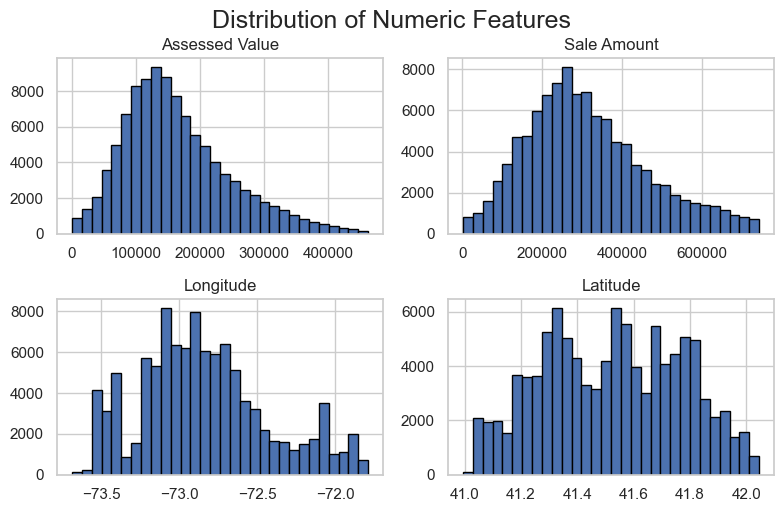

In [46]:
sns.set(style='whitegrid')
df.hist(figsize=(8, 5), bins=30, edgecolor='black')
plt.tight_layout()
plt.suptitle("Distribution of Numeric Features", fontsize=18, y=1.02)
plt.show()


Some of the features are right skewed. I performed the log transformation method but the prediction performance was poor so I had to continue without using log transform on Assessed Value and Sale Amount

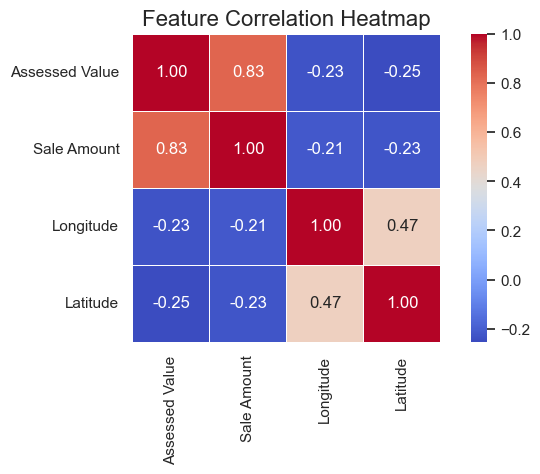

In [48]:
# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

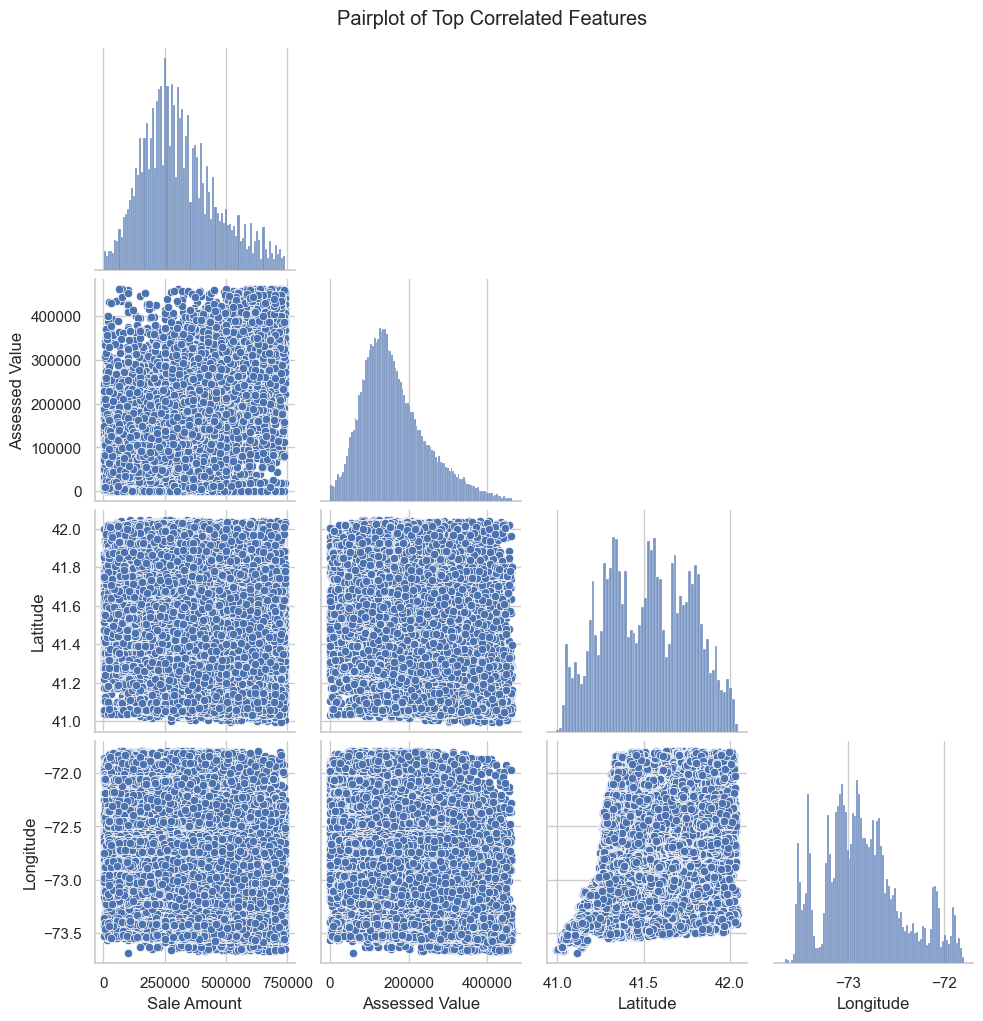

In [49]:
top_features = corr_matrix['Sale Amount'].abs().sort_values(ascending=False).head(5).index

sns.pairplot(df[top_features], corner=True)
plt.suptitle("Pairplot of Top Correlated Features", y=1.02)
plt.show()

## Train the Models

In [51]:
# Split features (X) and target (y)
X = df.drop("Sale Amount", axis=1)
y = df["Sale Amount"]

In [52]:
# Identify categorical columns
cat_cols = X.select_dtypes(include='object').columns.tolist()

# Identify numeric columns
num_cols = X.select_dtypes(include='number').columns.tolist()

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=8
)

In [54]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📊 {name} Model Evaluation:")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:.4f}")

In [55]:
# Train all four
evaluate_model("Ridge", Ridge(),X_train, X_test, y_train, y_test)
evaluate_model("XGBoost", XGBRegressor(random_state= 8),X_train, X_test, y_train, y_test)
evaluate_model("LightGBM", LGBMRegressor(random_state=8),X_train, X_test, y_train, y_test)
evaluate_model("DecisionTreeRegressor", DecisionTreeRegressor(max_depth=5),X_train, X_test, y_train, y_test)


📊 Ridge Model Evaluation:
MAE : 58,387.14
RMSE: 84,513.91
R²  : 0.6964

📊 XGBoost Model Evaluation:
MAE : 53,707.65
RMSE: 77,759.46
R²  : 0.7430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 82863, number of used features: 177
[LightGBM] [Info] Start training from score 311530.149778


C:\Users\ahmed\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ahmed\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ahmed\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ahmed\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ahmed\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro


📊 LightGBM Model Evaluation:
MAE : 54,121.97
RMSE: 78,468.03
R²  : 0.7383

📊 DecisionTreeRegressor Model Evaluation:
MAE : 57,761.47
RMSE: 82,436.12
R²  : 0.7112


In [56]:
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

# Fit the best_model on training data
best_model.fit(X_train, y_train)

# Predict
y_pred = best_model.predict(X_test)


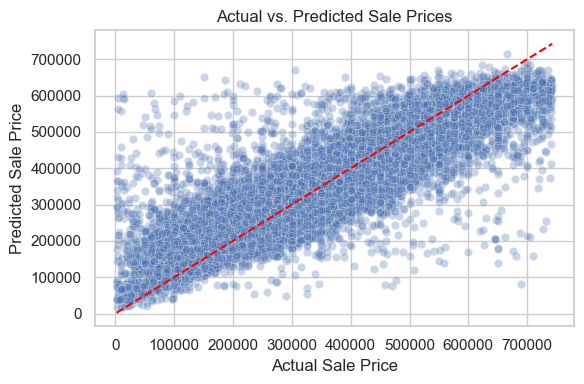

In [57]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.tight_layout()
plt.show()

Fine Tuning with Optuna

In [59]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
        "subsample": trial.suggest_float("subsample", 0.0,1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
    }

    xgb = XGBRegressor(**params, random_state=8)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", xgb)
    ])
    
    # Using 3-fold cross-validation and negative MAE (lower is better)
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")
    
    return -1.0 * score.mean()  # Return positive MAE for optimization


In [60]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("✅ Best trial:")
print("  Value: ", study.best_value)
print("  Params:", study.best_params)

[I 2025-08-04 11:23:25,904] A new study created in memory with name: no-name-242dab82-d218-49c7-8184-d79e46600d7b
[I 2025-08-04 11:23:27,854] Trial 0 finished with value: 54276.743638362736 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.11802263781104481, 'subsample': 0.22721874630880923, 'colsample_bytree': 0.8150694134001316, 'reg_alpha': 0.1667532552849854, 'reg_lambda': 1.5413355474676542}. Best is trial 0 with value: 54276.743638362736.
[I 2025-08-04 11:23:50,741] Trial 1 finished with value: 57748.81445575426 and parameters: {'n_estimators': 390, 'max_depth': 15, 'learning_rate': 0.0954613662111868, 'subsample': 0.8070893887445794, 'colsample_bytree': 0.8455355100791672, 'reg_alpha': 0.08412589678414106, 'reg_lambda': 0.01590169160903354}. Best is trial 0 with value: 54276.743638362736.
[I 2025-08-04 11:23:55,891] Trial 2 finished with value: 54300.062041819794 and parameters: {'n_estimators': 364, 'max_depth': 11, 'learning_rate': 0.13144359499163039, '

✅ Best trial:
  Value:  53481.460158647125
  Params: {'n_estimators': 387, 'max_depth': 9, 'learning_rate': 0.05369998044636322, 'subsample': 0.7910465554039875, 'colsample_bytree': 0.762526083159383, 'reg_alpha': 0.4061799524146095, 'reg_lambda': 0.8971334407602964}


In [61]:
best_params = study.best_params
final_xgb = XGBRegressor(**best_params, random_state=42)

xgb_optuna_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", final_xgb)
])

xgb_optuna_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Assessed Value',
                                                   'Longitude', 'Latitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Town', 'Property Type',
                                                   'Residential Type'])])),
                (...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05369998044636322, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=387, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = xgb_optuna_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("\n📊 Optuna Tuned XGBoost Evaluation:")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:.4f}")



📊 Optuna Tuned XGBoost Evaluation:
MAE : 53,415.02
RMSE: 77,228.23
R²  : 0.7465


C:\Users\ahmed\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


This was the results when I first worked on it

In [ ]:
📊 Optuna Tuned XGBoost Evaluation:
MAE : 52,478.41
RMSE: 75,572.41
R²  : 0.7550